In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
sys.path.insert(1, r'C:\Users\dexte\Documents\GitHub\pico_weight_scales')

## load data

In [20]:
folder_path=r"C:\Users\dexte\Documents\GitHub\pico_weight_scales\assets\data"
def load_and_label_sensor_csvs(folder_path):
    all_dfs = []

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, header=None)
            df.rename(columns={0: file.replace("grams_","").replace(".csv","")}, inplace=True)
            if type(all_dfs)==type([]):
                all_dfs=df
            else: all_dfs=pd.concat([all_dfs, df], axis=1)
    return all_dfs
df = load_and_label_sensor_csvs(folder_path)
if df is not None:
    print(df.head())    

         10       100       110        20        30        40        50  \
0  0.014502  0.024170  0.020948  0.017725  0.017725  0.019336  0.019336   
1  0.016919  0.023365  0.020948  0.015308  0.018530  0.016919  0.016919   
2  0.014502  0.016919  0.023365  0.015308  0.017725  0.019336  0.017725   
3  0.013697  0.024170  0.021753  0.015308  0.019336  0.020142  0.017725   
4  0.014502  0.024170  0.021753  0.015308  0.017725  0.019336  0.016919   

         60        70        80        90  
0  0.020142  0.020142  0.023365  0.023365  
1  0.020948  0.020142  0.014502  0.022559  
2  0.021753  0.020948  0.021753  0.025782  
3  0.021753  0.026587  0.024170  0.026587  
4  0.020948  0.013697  0.023365  0.026587  


## show data

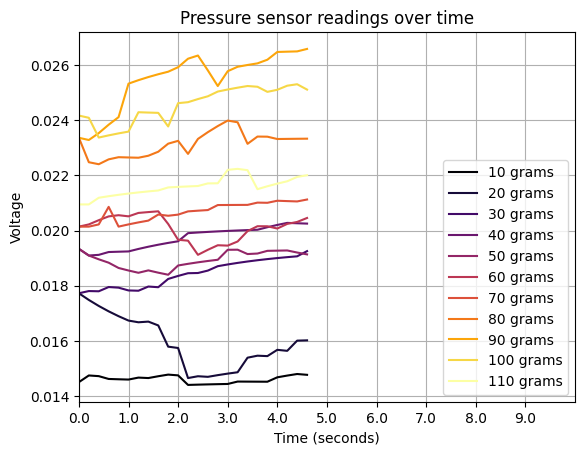

In [48]:
def low_pass(data,alpha=0.9):
    ar=[data[0]]
    for i in range(1,len(data)):
        ar.append(alpha*ar[i-1] + (1-alpha)*data[i])
    return np.array(ar)
keys=list(df.keys())
keys = sorted(keys, key=int)
colors = plt.cm.inferno(np.linspace(0, 1, len(keys)))  # Generate colors
X=[]
for i in range(len(keys)):
    key=keys[i]
    plt.plot(low_pass(df[key]),label=key+" grams", color=colors[i])
    x=np.array(low_pass(df[key]))
    X.append(np.average(x[~np.isnan(x)]))

plt.ylabel("Voltage")
plt.xlim([0,50])
plt.xticks([i for i in range(0,50,5)],[0.2*i for i in range(0,50,5)])
plt.grid(1)
plt.xlabel("Time (seconds)")
plt.legend(loc="lower right")
plt.title("Pressure sensor readings over time")
plt.show()

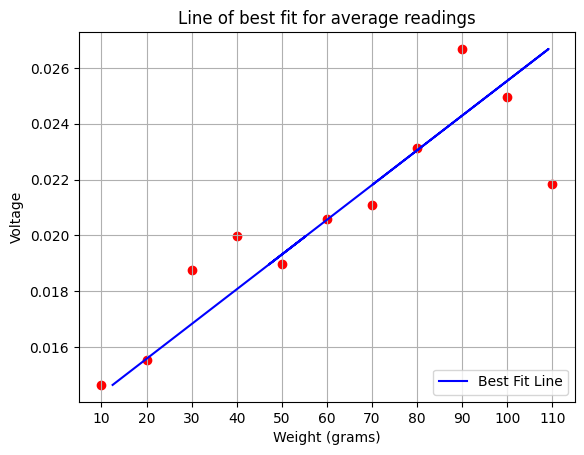

In [35]:
X=np.array(X)
y=np.array([i for i in range(len(X))])
m, b = np.polyfit(X,y, 1)

# Generate the best-fit line
Y_fit = m * X + b
def predict(value):
    Y_fit = m * value + b
    return Y_fit
plt.scatter([i for i in range(len(X))],X,c="r")
plt.xticks([i for i in range(len(X))],[((i+1)*10) for i in range(len(X))])
plt.plot(Y_fit,X, color="blue", label="Best Fit Line")  # Plot line
plt.title("Line of best fit for average readings")
plt.ylabel("Voltage")
plt.xlabel("Weight (grams)")
plt.grid(1)
plt.legend(loc="lower right")
plt.show()


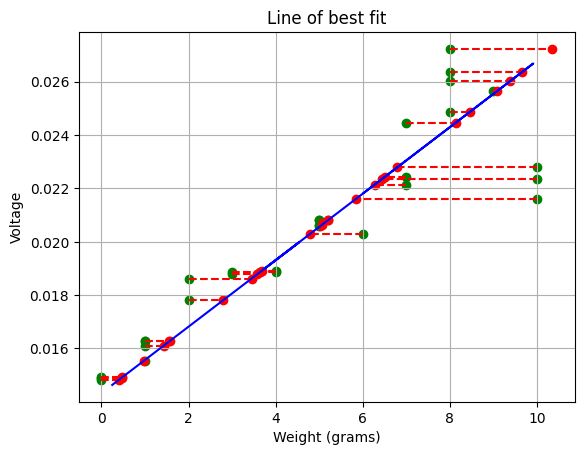

In [44]:
for i in range(len(keys)):
    key=keys[i]
    data=low_pass(df[key])
    for j in range(4):
        val=np.random.choice(data)
        pred=predict(val)
        plt.scatter(int(i),val, color="g")
        plt.scatter(pred, val, color="r")
        plt.plot([i,pred],[val,val],"--",c="r")

#plt.xticks([i for i in range(len(X))],[((i+1)*10) for i in range(len(X))])
plt.plot(Y_fit,X, color="blue", label="Best Fit Line")  # Plot line
plt.title("Line of best fit")
plt.ylabel("Voltage")
plt.xlabel("Weight (grams)")
plt.grid(1)
plt.show()


## regression

(264,) (264,)
Mean Squared Error: 234.669025797674
Mean Squared Error: 195.08297428517668


Text(0.5, 1.0, 'Linear regression model predicting weight from voltage')

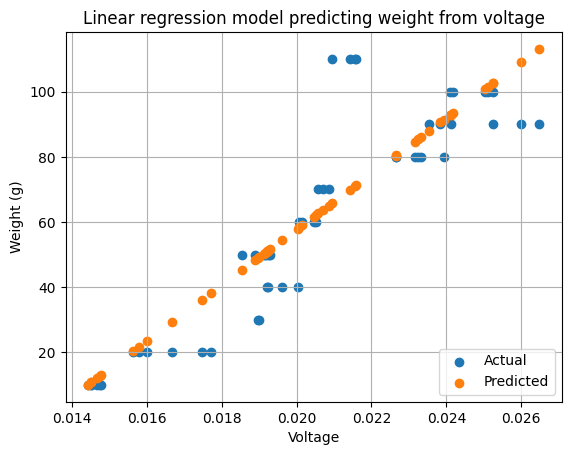

In [ ]:
df=df.dropna()
X=np.array([])
y=np.array([])
for i in range(len(keys)):
    key=keys[i]
    vals=df[key].values
    vals=low_pass(vals)
    X=np.concatenate([X,vals])
    y=np.concatenate([y,np.array([int(key) for j in range(len(vals))])])
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.2, random_state=42) #this splits

#train the model
model = LinearRegression()
model.fit(X_train, y_train)

#work out how good the model is on the train data
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

#work out how good the model is on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test,y_test,label="Actual")
plt.scatter(X_test,y_pred,label="Predicted")
plt.grid(1)
plt.legend(loc="lower right")
plt.xlabel("Voltage")
plt.ylabel("Weight (g)")
plt.title("Linear regression model predicting weight from voltage")

(264,) (264,)
Mean Squared Error: 11.14774514983719
Mean Squared Error: 46.443604821802936


Text(0.5, 1.0, 'Linear regression model predicting weight from voltage')

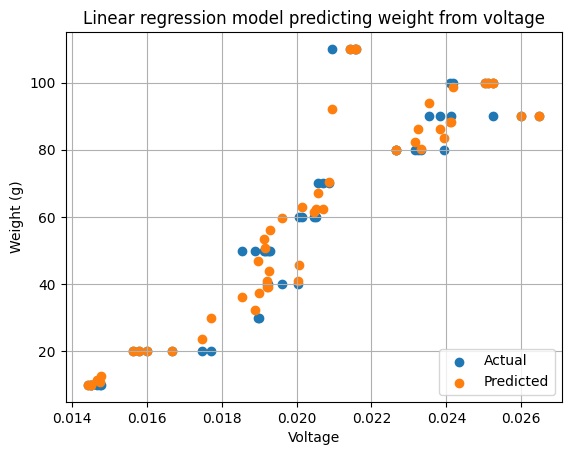

In [55]:
df=df.dropna()
X=np.array([])
y=np.array([])
for i in range(len(keys)):
    key=keys[i]
    vals=df[key].values
    vals=low_pass(vals)
    X=np.concatenate([X,vals])
    y=np.concatenate([y,np.array([int(key) for j in range(len(vals))])])
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size=0.2, random_state=42) #this splits

#train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#work out how good the model is on the train data
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

#work out how good the model is on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test,y_test,label="Actual")
plt.scatter(X_test,y_pred,label="Predicted")
plt.grid(1)
plt.legend(loc="lower right")
plt.xlabel("Voltage")
plt.ylabel("Weight (g)")
plt.title("Linear regression model predicting weight from voltage")

In [57]:
tree = model.estimators_[0].tree_

# Print a manual decision tree to hardcode in CircuitPython
def extract_rules(tree, feature_names=["Water", "Sunlight"]):
    """Extracts simple if-else rules from the tree"""
    rules = []
    
    def traverse(node, condition=""):
        if tree.children_left[node] == -1:  # Leaf node
            rules.append(f"{condition} -> Predict: {tree.value[node][0][0]}")
            return
        
        feature = feature_names[tree.feature[node]]
        threshold = tree.threshold[node]
        
        left_condition = f"{condition}if {feature} <= {threshold:.5f} "
        right_condition = f"{condition}if {feature} > {threshold:.5f} "
        
        traverse(tree.children_left[node], left_condition)
        traverse(tree.children_right[node], right_condition)
    
    traverse(0)
    return rules

rules = extract_rules(tree)

print("\nExtracted Rules for CircuitPython:")
for rule in rules:
    print(rule)



Extracted Rules for CircuitPython:
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water <= 0.01463  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water <= 0.01470 if Water <= 0.01465  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water <= 0.01470 if Water > 0.01465  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water <= 0.01476 if Water > 0.01470  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water <= 0.01479 if Water > 0.01476  -> Predict: 10.0
if Water <= 0.02029 if Water <= 0.01838 if Water <= 0.01753 if Water > 0.01463 if Water > 0.01479  -> Predict: 20.0
if Water <= 0.02029 if Water <= 0.01838 if Water > 0.01753  -> Predict: 30.0
if Water <= 0.02029 if Water